**AutoEncoder**

In [ ]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image


In [ ]:

# Data Preprocessing

# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
transform = transforms.Compose([transforms.ToTensor()])
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=2)
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:

# Defining Model

class Autoencoder(nn.Module):

    def __init__(self, input_size = 784, latent_layer = 10, output_size = 784):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_layer),
            nn.ReLU(True),
            )

        self.decoder = nn.Sequential(             
            
            nn.Linear(latent_layer, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, output_size),
            nn.ReLU(True),
            )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [ ]:

# Defining Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
batch_size = 128
model = Autoencoder().to(device)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)


In [ ]:
# Training

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = Variable(img).to(device)
        # ===================forward=====================
        img = img.view(-1,784).to(device)
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/5], loss:0.0357
epoch [2/5], loss:0.0301
epoch [3/5], loss:0.0274
epoch [4/5], loss:0.0260
epoch [5/5], loss:0.0240


Original Image


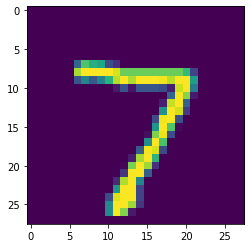

Reconstructed Image


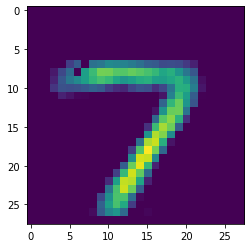

In [ ]:

import matplotlib.pyplot as plt
for i, data in enumerate(testloader):
  img, _ = data
  img = Variable(img).to(device)
  img = img.view(-1,784).to(device)
  output = model(img)
  print("Original Image")
  plt.imshow(img.detach().cpu().numpy()[0].reshape(28,28)) 
  plt.show()

  print("Reconstructed Image")
  plt.imshow(output.detach().cpu().numpy()[0].reshape(28,28))
  plt.show()
  break

**Variational AutoEnoders**

In [ ]:

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
VAE()

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

In [ ]:

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [ ]:
for epoch in range(1, 15):
  model.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(dataloader):
# ===================forward=====================
      data = data.to(device)
      optimizer.zero_grad()
      recon_batch, mu, logvar = model(data)
      loss = loss_function(recon_batch, data, mu, logvar)
# ===================backward====================
      loss.backward()
      train_loss += loss.item()
      optimizer.step()
# ===================log========================
  print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(dataloader.dataset)))

====> Epoch: 1 Average loss: 137.9054
====> Epoch: 2 Average loss: 113.7874
====> Epoch: 3 Average loss: 110.4890
====> Epoch: 4 Average loss: 108.8996
====> Epoch: 5 Average loss: 107.9842
====> Epoch: 6 Average loss: 107.2612
====> Epoch: 7 Average loss: 106.7854
====> Epoch: 8 Average loss: 106.3634
====> Epoch: 9 Average loss: 105.9673
====> Epoch: 10 Average loss: 105.7023
====> Epoch: 11 Average loss: 105.4296
====> Epoch: 12 Average loss: 105.1734
====> Epoch: 13 Average loss: 105.0236
====> Epoch: 14 Average loss: 104.7694


torch.Size([1, 784])
Sample Image


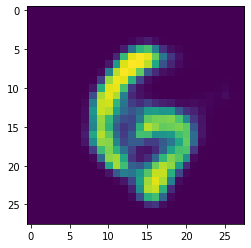

In [ ]:
with torch.no_grad():
  sample = torch.randn(1, 20).to(device)
  sample = model.decode(sample).cpu()
  print(sample.shape)
  print("Sample Image")
  plt.imshow(sample.detach().cpu().numpy()[0].reshape(28,28)) 
  plt.show()


**GAN**

In [ ]:
import numpy as np
latent_dim = 100
img_shape = (28,28)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Sigmoid()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()
lr = 0.0002
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr= lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


In [ ]:
n_epochs = 100

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
    print(
        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
    )

In [ ]:
from torch.utils.data import sampler
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))).to(device)
sample = generator(z)
if torch.cuda.is_available():
    sample = sample.detach().cpu().numpy()
else:
    sample = sample.detach().numpy()
plt.imshow(sample[0])
plt.show()